## Predicting Survival on the Titanic using Logistic Regression

My model will use the independent variables sex, age, fare, pclass, sibsp, parch, and embarked to predict the dependent variable survived.

## Data Preparation

In [673]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [674]:
#reading the data from the disk into memory
df = pd.read_csv("train.csv")

In [675]:
#Create the dataframe including all variables that are going to be used
X = pd.DataFrame()
X['sex'] = df['Sex']
X['age'] = df['Age']
X['fare'] = df['Fare']
X['pclass'] = df['Pclass']
X['sibsp'] = df['SibSp']
X['parch'] = df['Parch']
X['embarked'] = df['Embarked']
X['survived'] = df['Survived']

In [676]:
#The only attribute with missing values from the set I chose is the "Age" group.
#The mean age of all passengers on the ship was about 29-years-old.
#Replace all missing "Age" features with this mean value.
#I read of using logistic regression to calculate missing values such as these, but doing this resulted in a
#satisfactory AUC score.
X['age'] = [x if pd.notnull(x) else 29.0 for x in X['age']]

In [677]:
#Separate our dependent variable from the independent variables in order to make the training and test sets.
y = X['survived']
X = X.drop(['survived'], axis=1)

In [678]:
#"One hot encode" attributes that are not numerical.
#Remove one attribute from each set in order to prevent co-linearity in the training set.
#The attribute that was removed will have its value for each instance inferred to be 1 should
#the remaining attributes all be 0.
X['sex'] = pd.get_dummies(X.sex)['female']
X['embarked'] = pd.get_dummies(X['embarked'], drop_first=True)

In [679]:
#Normalize the features
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [680]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Base Rate Model
For the baserate model, I'm going to predict that everyone dies. 
This is analagous to the ZeroR classification model -- take whichever classification is most
numerous in the the set and classify everything as that. It just makes a smart wager.

In [681]:
#This function looks for females in the test set and returns 1, survived, otherwise it returns 0
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y
    

In [682]:
#how accurate is my base rate model?
y_base_rate = base_rate_model(X_test)
from sklearn.metrics import accuracy_score
print("Base rate accuracy is %2.2f" % accuracy_score(y_test, y_base_rate))

Base rate accuracy is 0.59


The base model is 59% correct.

In [683]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)

In [690]:
#Train the LogisticRegression model on the 80%, ordinally matched, attribute/classifier sets
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [685]:
print("Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test)))

Logistic accuracy is 0.81


I left this analogy here because I like it and it explains the subject-specific vocabulary very well.

Think of fishing with a net for tuna.   
*  If our net is very precise, and has high recall it will catch any and all tuna and ONLY tuna.
*  If our net is very precise, but has low recall then we might catch one tuna, but most will escape.
*  If our net is low precision, but has high recall, then we might catch tuna, but also any other fish around
*  If our net is low precision, and low recall, then we should probably give up fishing.   


In [686]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [687]:
print("---Base Model---")
#base rate AUC
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print("Base Rate AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test,base_rate_model(X_test) ))
print("\n\n---Logistic Model---")
#logistic AUC
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, model.predict(X_test) ))

---Base Model---
Base Rate AUC = 0.50
             precision    recall  f1-score   support

          0       0.59      1.00      0.74       105
          1       0.00      0.00      0.00        74

avg / total       0.34      0.59      0.43       179



---Logistic Model---
Logistic AUC = 0.80
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       105
          1       0.80      0.72      0.76        74

avg / total       0.81      0.81      0.81       179



In [688]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

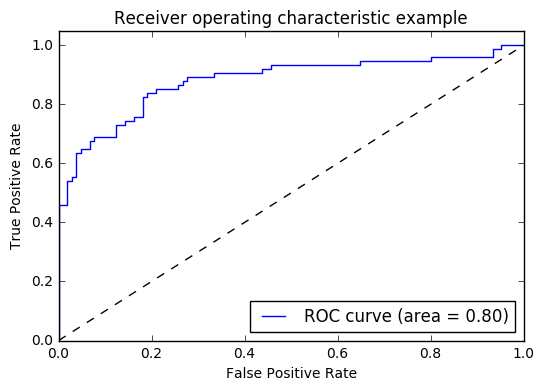

In [689]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()